In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams["figure.figsize"] = [12,12]
a = 17
b = 19
def f(x): 
    return a * x[0] ** 2 + b * (x[0] - x[1]) ** 2 - x[0] - 2 * x[1]
def grad_f(x):
    return np.array([2 * a * x[0] + 2 * b * (x[0] - x[1]) - 1, -2 * b * x[0] + 2 * b * x[1] - 2])
def hessian_f(x, y):
    return np.array([[2 * a + 2 * b, -2 * b], [-2 * b, 2 * b]])
def eig_hessian_f():
    return np.array([-np.sqrt(a ** 2 + 4 * b ** 2) + a + 2 * b, np.sqrt(a ** 2 + 4 * b ** 2) + a + 2 * b])

lambdas = -eig_hessian_f()
lambdas.sort()
lambdas = -lambdas

theta = 1.4
dzeta = 0.2
def func(x):
    return 0.5 * (theta * (x[0] - x[1]) ** 2 + dzeta * (x[0] + x[1]) ** 2)
def animate_trajectory(traj, minx, miny):
    fig, ax = plt.subplots()
    n = len(traj)
    def step(t):
        ax.cla()
        ax.plot([minx], [miny], 'o', color='green')
        #Level contours
        delta = 0.025
        x = np.arange(-3, 3, delta)
        y = np.arange(-3, 3, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        #print(X.shape, Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = func([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, [0.5, 1.5, 3], colors=['blue', 'purple', 'red'])
        
        ax.plot([u[0] for u in traj[:t]], [u[1] for u in traj[:t]], color='black')
        ax.plot([u[0] for u in traj[:t]], [u[1] for u in traj[:t]], 'o', color='black')
        
        fix_scaling(ax)
        ax.axis('off')

    return FuncAnimation(fig, step,
                     frames=range(n), interval=600)
def animate_trajectories(traj_array, limit):
    fig, ax = plt.subplots()
    n = limit
    def step(t):
        ax.cla()
        ax.plot([0], [0], 'o', color='green')
        #Level contours
        delta = 0.025
        x = np.arange(-3, 3, delta)
        y = np.arange(-3, 3, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        #print(X.shape, Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = func([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, [0.5, 1.5, 3], colors=['blue', 'purple', 'red'])
    
        colors = ['black', 'yellow', 'red', 'green']
        i = 0
        for traj in traj_array:
            ax.plot([u[0] for u in traj[:t]], [u[1] for u in traj[:t]], color=colors[i])
            ax.plot([u[0] for u in traj[:t]], [u[1] for u in traj[:t]], 'o', color=colors[i])
            i += 1
        
        fix_scaling(ax)
        ax.axis('off')

    return FuncAnimation(fig, step,
                     frames=range(n), interval=600)
def fix_scaling(ax=None):
    if not ax:
        xlim = plt.xlim()
        ylim = plt.ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            plt.ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            plt.xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))
    else:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            ax.set_ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            ax.set_xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))


In [2]:
######################################## Task 1.2 ########################################

In [3]:
plt.rcParams["figure.figsize"] = [12,12]

#Gradient of f - recursive
def gd_f(x, alpha, limit):
    if (limit == 0): return x
    return gd_f(x - grad_f(x).dot(alpha), alpha, limit - 1)

#Gradient of f - iterative
def gd_f_nonrec(x, limit):
    alpha = (2.0 / (sum(list(eig_hessian_f()))))
    if (limit == 0): return [x]
    traj_opt_step = [x]
    while(limit > 0):
        x = x - grad_f(x).dot(alpha)
        traj_opt_step.append(x)
        limit -= 1
    return traj_opt_step

#Heavy ball
def heavy_ball_f(x, limit):
    alpha = alpha = 4.0 / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1])) ** 2
    beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
    traj_heavy_ball = []
    x_start = x
    traj_heavy_ball.append(x_start.copy())
    cur_x = x_start.copy()
    prev_x = x_start.copy()
    for i in range(limit):
        t = cur_x
        cur_x = cur_x - alpha * grad_f(cur_x) + beta * (cur_x - prev_x)
        prev_x = t
        traj_heavy_ball.append(cur_x.copy())
    return traj_heavy_ball

#Chebyshev
def chebyshev(x, limit):
    phi = (lambdas[0] + lambdas[1]) / (lambdas[0] - lambdas[1])
    cur_gamma   = 1.0 / phi
    prev_gamma  = 0
    print(phi - np.sqrt(phi ** 2 - 1))
    print('phi', phi)
    traj_chebyshev = []
    x_start = x
    traj_chebyshev.append(x_start.copy())
    cur_x = x_start.copy()
    prev_x = x_start.copy()
    for i in range(limit):
        t = cur_x
        alpha = 4 * cur_gamma / (lambdas[0] - lambdas[1])
        beta = cur_gamma * prev_gamma
        cur_x = cur_x - alpha * grad_f(cur_x) + beta * (cur_x - prev_x)
        prev_x = t
        t = cur_gamma
        cur_gamma = 1.0 / (2 * phi - cur_gamma)
        prev_gamma = t
        traj_chebyshev.append(cur_x.copy())
    return traj_chebyshev

#Nesterov
def nesterov(x, limit):
    alpha = 1 / (lambdas[0] + 1)
    beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
    traj_nesterov = []
    x_start = x
    traj_nesterov.append(x_start.copy())
    cur_x = x_start.copy()
    cur_y = x_start.copy()
    
    for i in range(limit):
        t = cur_x
        cur_x = cur_y - alpha * grad_f(cur_y)
        cur_y = cur_x + beta * (cur_x - t)
        traj_nesterov.append(cur_x.copy())
    return traj_nesterov

#Returns minimum of f, solves grad F = 0
def gradSolve():
    return np.linalg.solve([[2 * a + 2 * b, -2 * b],[-2 * b,2 * b]], np.array([1,2]))

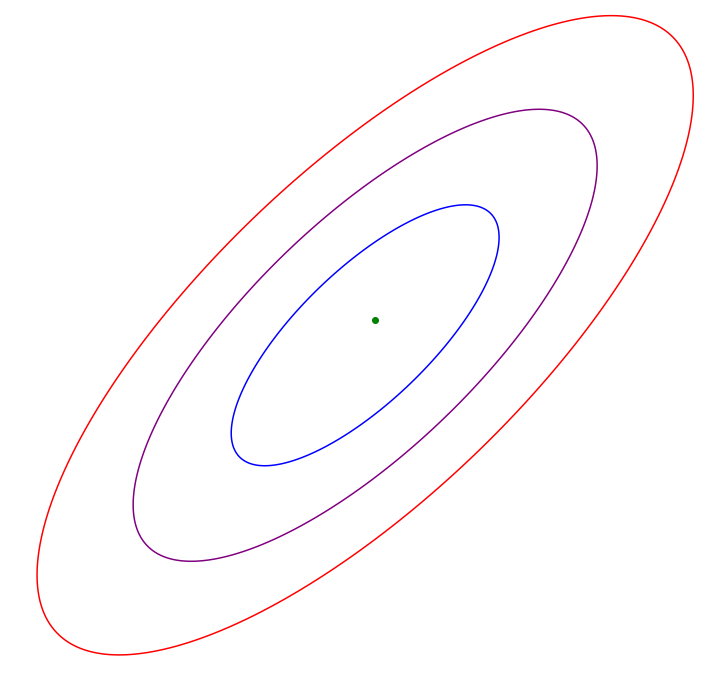

In [4]:
#Gradient descent with optimal alpha

x = np.array([3,3])
limit = 16
base_animation = animate_trajectory(gd_f_nonrec(x, limit), 3/34, 91/646)
HTML(base_animation.to_jshtml())

0.45774468687729064
phi 1.3211843119531743


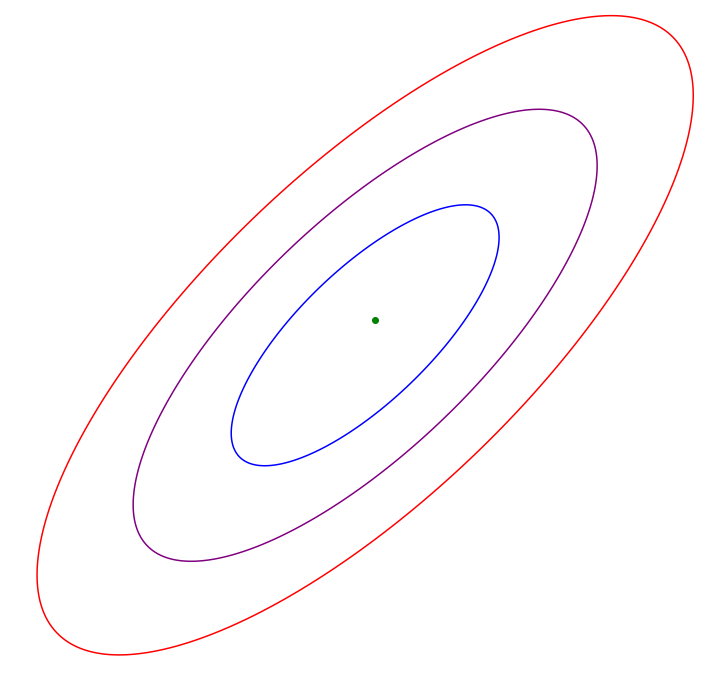

In [5]:
#Chebyshev

x = np.array([3,3])
limit = 16
base_animation = animate_trajectory(chebyshev(x, limit), 3/34, 91/646)
HTML(base_animation.to_jshtml())

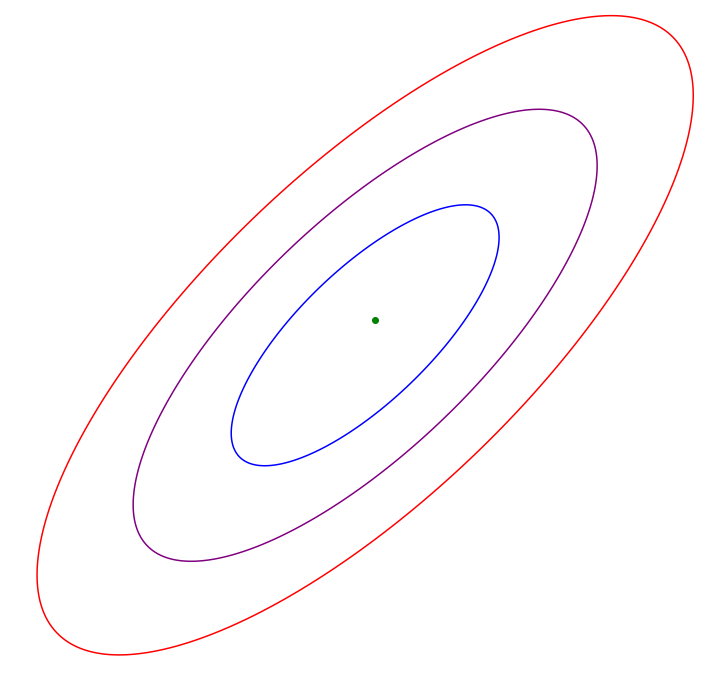

In [6]:
#Nesterov

x = np.array([3,3])
limit = 16
base_animation = animate_trajectory(nesterov(x, limit), 3/34, 91/646)
HTML(base_animation.to_jshtml())

In [7]:
######################################## Task 1.3 ########################################

In [8]:
#Minimum value and minimum

print(gradSolve())
print(f(gradSolve()))

[0.08823529 0.14086687]
-0.18498452012383898


0.45774468687729064
phi 1.3211843119531743


[]

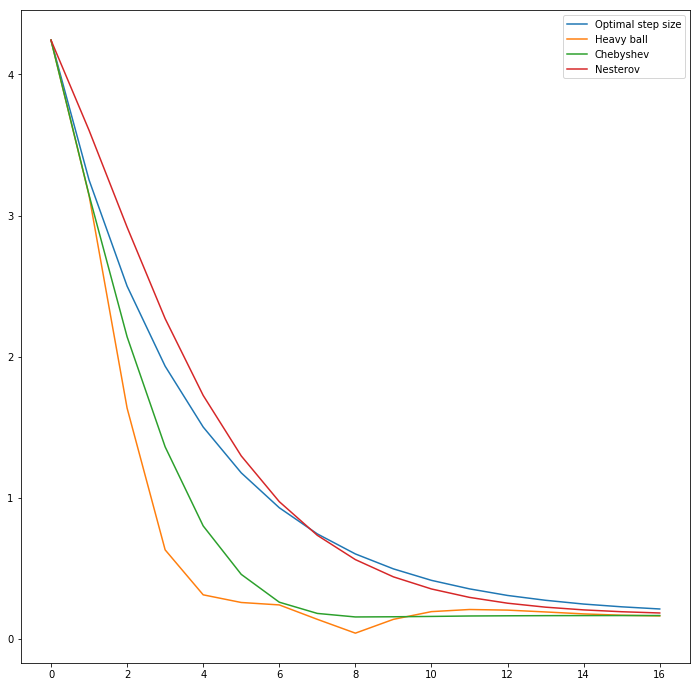

In [9]:
#Comparison of methods - norm of arguments

fig, ax = plt.subplots()
x = np.array([3,3])
limit = 16
u = gd_f_nonrec(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t) for t in u], label='Optimal step size')
u = heavy_ball_f(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t) for t in u], label='Heavy ball')
u = chebyshev(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t) for t in u], label='Chebyshev')
u = nesterov(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t) for t in u], label='Nesterov')
plt.legend()
plt.plot()

0.45774468687729064
phi 1.3211843119531743


[]

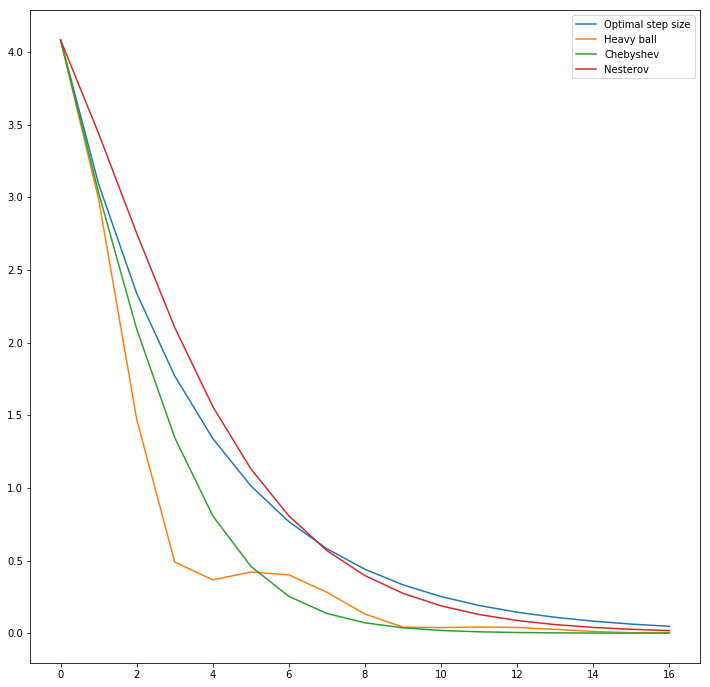

In [10]:
#Comparison of methods - norm of arg - min

plt.rcParams["figure.figsize"] = [12,12]
fig, ax = plt.subplots()
x = np.array([3,3])
x0 = gradSolve()
limit = 16
u = gd_f_nonrec(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t - x0) for t in u], label='Optimal step size')
u = heavy_ball_f(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t - x0) for t in u], label='Heavy ball')
u = chebyshev(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t - x0) for t in u], label='Chebyshev')
u = nesterov(x, limit)
ax.plot(range(limit + 1), [np.linalg.norm(t - x0) for t in u], label='Nesterov')
plt.legend()
plt.plot()

0.45774468687729064
phi 1.3211843119531743


[]

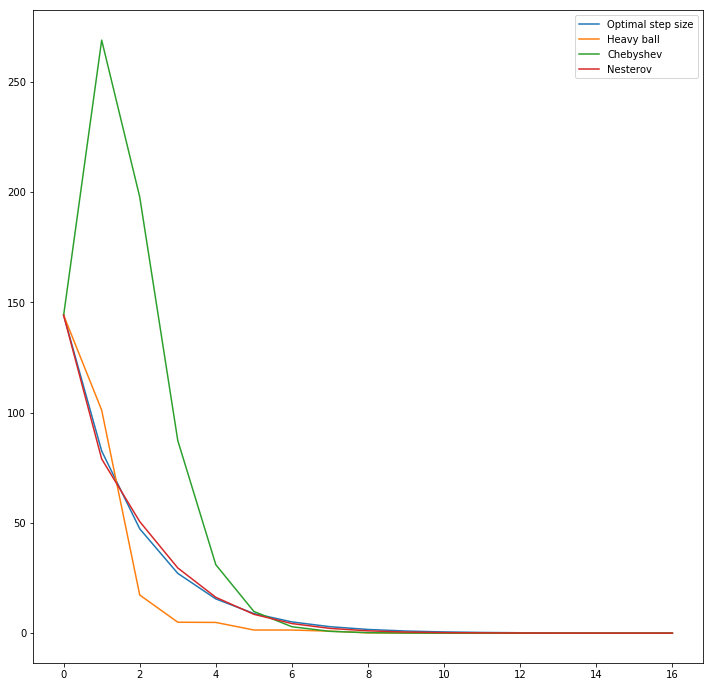

In [11]:
#Comparison of methods - f(arg) - f(min)

plt.rcParams["figure.figsize"] = [12,12]
fig, ax = plt.subplots()
x = np.array([3,3])
x0 = gradSolve()
limit = 16
u = gd_f_nonrec(x, limit)
ax.plot(range(limit + 1), [f(t) - f(x0) for t in u], label='Optimal step size')
u = heavy_ball_f(x, limit)
ax.plot(range(limit + 1), [f(t) - f(x0) for t in u], label='Heavy ball')
u = chebyshev(x, limit)
ax.plot(range(limit + 1), [f(t) - f(x0) for t in u], label='Chebyshev')
u = nesterov(x, limit)
ax.plot(range(limit + 1), [f(t) - f(x0) for t in u], label='Nesterov')
plt.legend()
plt.plot()

In [12]:
######################################## Task 1.4 ########################################

0.45774468687729064
phi 1.3211843119531743


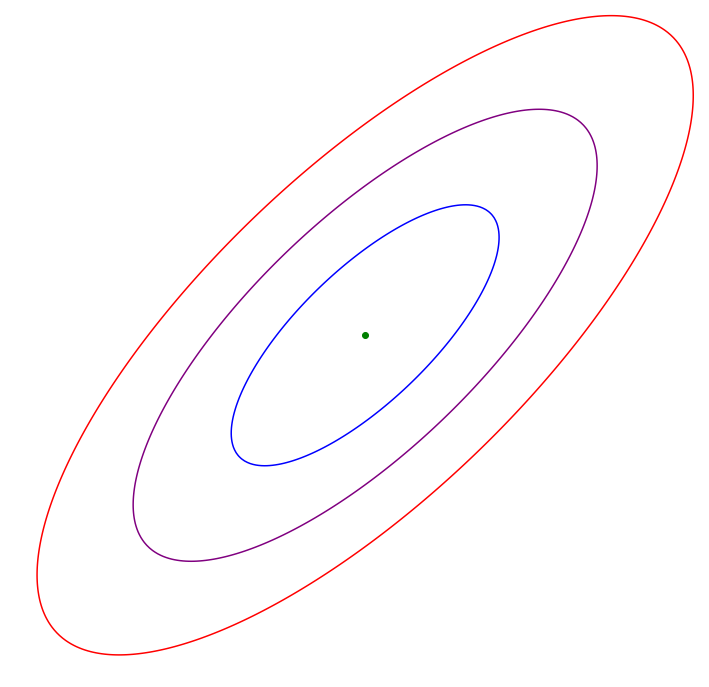

In [13]:
#Animation for all methods 

x = np.array([-10,-10])
limit = 16
base_animation = animate_trajectories(np.array([gd_f_nonrec(x, limit), 
                                                heavy_ball_f(x, limit), 
                                                chebyshev(x, limit), 
                                                nesterov(x, limit)]), limit)
HTML(base_animation.to_jshtml())

In [14]:
######################################## Task 2.1 ########################################

In [24]:
import math
def g(x): 
    return math.exp(x[0] + 3 * x[1]) + math.exp(x[0] - 3 * x[1]) + math.exp(-x[0])
def grad_g(x):
    return np.array([math.exp(x[0] - 3 * x[1]) + math.exp(x[0] + 3 * x[1]) - math.exp(-x[0]), 
            3 * (math.exp(6 * x[1]) - 1) * math.exp(x[0] - 3 * x[1])])
def hessian_g(x):
    return np.array([[math.exp(x[0] - 3 * x[1]) + math.exp(x[0] + 3 * x[1]), 
                      -3 * math.exp(x[0] - 3 * x[1]) + 3 * math.exp(x[0] + 3 * x[1])],
                     [-3 * math.exp(x[0] - 3 * x[1]) + 3 * math.exp(x[0] + 3 * x[1]),
                     9 * math.exp(x[0] - 3 * x[1]) + 9 * math.exp(x[0] + 3 * x[1]) + math.exp(-x[1])]])

In [ ]:
######################################## Task 2.2 ########################################

In [49]:
constL = -1000
for i in np.linspace(-100,100) / 100:
    constL = max([max(np.linalg.eig(hessian_g(np.array([i, 1])))[0]), 
                  max(np.linalg.eig(hessian_g(np.array([1, i])))[0]),
                  max(np.linalg.eig(hessian_g(np.array([i, -1])))[0]), 
                  max(np.linalg.eig(hessian_g(np.array([-1, i])))[0]), constL])
print(constL)

549.2980129121671


In [16]:
######################################## Task 3.1 ########################################

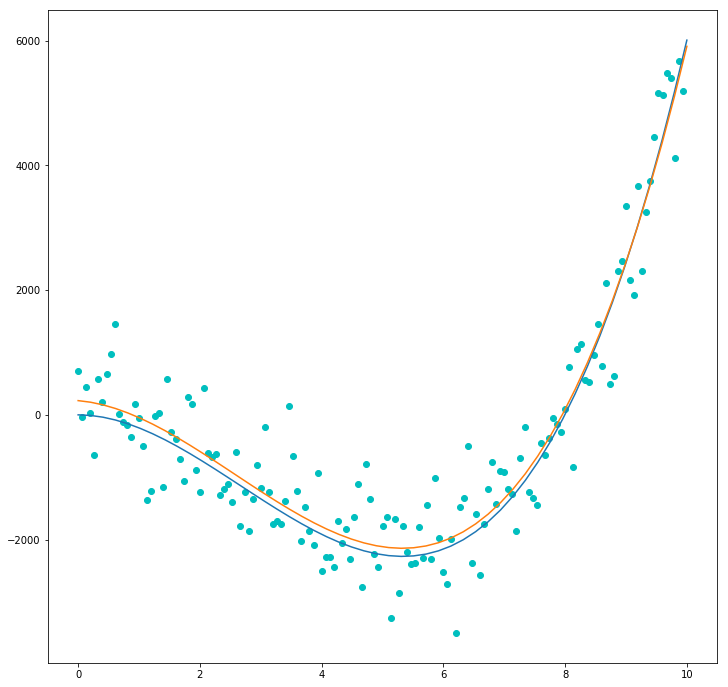

In [17]:
plt.rcParams["figure.figsize"] = [12,12]
deg = 3

def poly(x):
    return 1 * x - 240 * x **2 + 30 * x ** 3 
def d():
    return np.random.normal(0, 600)
def dots():
    xs = [i / 15 for i in range(0, 150)]
    ys = [poly(x) + d() for x in xs]
    plt.plot(xs, ys, 'co')
    return xs, ys
def getCoef(dots):
    xs, ys = dots
    m = np.array([[sum([x ** (i + j) for x in xs]) for j in range(0, deg + 1)] for i in range(0, deg + 1)])
    val = np.array([sum([y * x ** i for x, y in zip(xs, ys)]) for i in range(0, deg + 1)])
    return np.linalg.solve(m, val)

xs = np.linspace(0,10)
ys = poly(xs)
coef = getCoef(dots())
result = coef[0] * xs ** 0 + coef[1] * xs ** 1 + coef[2] * xs ** 2 + coef[3] * xs ** 3
plt.plot(xs, ys)
plt.plot(xs, result)
plt.show()